In [1]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
path = r"/kaggle/input/dataset-hw2-ann/"
x_train = np.load(path + r'x_train.npy')
y_train = np.load(path + r'y_train.npy')

In [4]:
x_train.shape, y_train.shape 

((2429, 36, 6), (2429,))

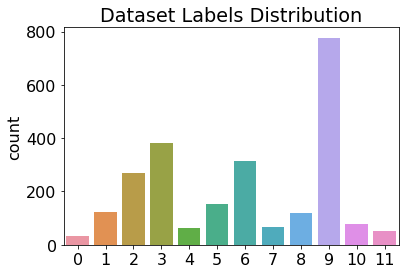

In [5]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

In [6]:
labels = np.unique(np.fromiter([i for i in y_train], np.int32) )
y_train = tfk.utils.to_categorical(y_train) 

In [7]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train) 

In [8]:
train_data = np.concatenate([x for x in x_train]) 
scaler = preprocessing.StandardScaler().fit(train_data)

x_train_trans = [] 
for el in x_train: 
    x_train_trans.append(scaler.transform(el))
del x_train 

x_test_trans = [] 
for el in x_test :
    x_test_trans.append(scaler.transform(el))

x_train = np.asarray(x_train_trans) 
x_test = np.asarray(x_test_trans)
#x_train

In [9]:
# check 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 
x_train[0][1]
y_train[0]

(1943, 36, 6) (1943, 12) (486, 36, 6) (486, 12)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

# **CNN**

In [10]:
in_shape = (36,6)

In [11]:
def build_model(hp):
    l2 = hp.Float("l2", min_value=1e-4, max_value=1e-2, step=4e-4)
    dropout_rate = hp.Float("drop_rate", min_value=0.0, max_value=.5, step=.05)
    filter_size = hp.Int("filter_size", min_value=3, max_value=21, step=3)
    #output_filters = hp.Int("output_filters", min_value=64, max_value=512, step=64)
    
    input_layer = tfkl.Input(shape=(36,6), name='Input')
    
    cnn = tfkl.Conv1D(hp.Int("output_filters1", min_value=64, max_value=512, step=64),
                      hp.Int("filter_size1", min_value=3, max_value=21, step=3),
                      padding='same',activation='relu')(input_layer) 
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(hp.Int("output_filters2", min_value=64, max_value=512, step=64),
                      hp.Int("filter_size2", min_value=3, max_value=21, step=3),
                      padding='same',
                      activation='relu')(input_layer) 
    cnn = tfkl.MaxPooling1D()(cnn)
    out_3 = hp.Int("output_filters3", min_value=64, max_value=512, step=64)
    cnn = tfkl.Conv1D(out_3,
                      hp.Int("filter_size3", min_value=3, max_value=21, step=3),
                      padding='same',activation='relu')(input_layer) 
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(dropout_rate, seed=seed)(gap)

    '''
    hidden_layer1 = tfkl.Dense(units= hp.Int("units_1", min_value=32, max_value=512, step=32),
                               activation ='relu',
                               name = 'Hidden1',
                               kernel_regularizer = tfk.regularizers.L2(l2))(dropout) 

    hidden_layer2 = tfkl.Dense(units= hp.Int("units_2", min_value=32, max_value=512, step=32), 
                               activation ='relu',
                               name = 'Hidden2', 
                               kernel_regularizer = tfk.regularizers.L2(l2))(hidden_layer1) 
    
    
    classifier = tfk.Sequential([ 
        tfkl.Input(shape=(output_filters,)), 
        tfkl.experimental.RandomFourierFeatures(output_dim=hp.Int("output_dim", min_value=1024, max_value=8192, step=512),
                                                scale=hp.Float("scale", min_value=1, max_value=16, step=.5), 
                                                kernel_initializer="gaussian"),
        tfkl.Dense(units=128,  activation='relu', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   name='dense_classifier1',
                   kernel_regularizer = tfk.regularizers.L2(l2)                  
                  ),
        tfkl.Dense(units=128,  activation='relu', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   name='dense_classifier2',
                   kernel_regularizer = tfk.regularizers.L2(l2)                    
                  )
    ]) (gap)  
    '''
    
    classifier = tfk.Sequential()
    classifier.add(tfkl.Input(shape=out_3))
    classifier.add(tfkl.experimental.RandomFourierFeatures(output_dim=hp.Int("output_dim", min_value=1024, max_value=8192, step=512),
                                                scale=hp.Float("scale", min_value=1, max_value=16, step=.5), 
                                                kernel_initializer="gaussian"))
    
    for i in range(hp.Int("num_layers", 1, 3)):
        classifier.add(
            tfkl.Dense(
                units=hp.Int(f"c_units_{i}", min_value=32, max_value=512, step=32),
                activation='relu',
                kernel_regularizer = tfk.regularizers.L2(l2)
            )
        )
    
    x = classifier(gap) 
    output_layer = tfkl.Dense(12, activation='softmax', 
                              kernel_regularizer = tfk.regularizers.L2(l2),
                              kernel_initializer=tfk.initializers.GlorotUniform(seed))(x)
      
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

# Keras Tuner

In [12]:
import keras_tuner
from tensorflow import keras
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=4, #maybe with random search may help 
    overwrite=True,
    directory="KT_experiments",
    project_name="tuner",
)


2022-12-12 00:24:13.692869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 00:24:13.837519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 00:24:13.838347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 00:24:13.839555: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
tuner.search(x_train, y_train, epochs=60, validation_data=(x_test, y_test))

Trial 20 Complete [00h 01m 21s]
val_accuracy: 0.5354938060045242

Best val_accuracy So Far: 0.5648148357868195
Total elapsed time: 00h 25m 56s


In [14]:
tuner.search_space_summary()


Search space summary
Default search space size: 15
l2 (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': 0.0004, 'sampling': None}
drop_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
filter_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 21, 'step': 3, 'sampling': None}
output_filters1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
filter_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 21, 'step': 3, 'sampling': None}
output_filters2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
filter_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 21, 'step': 3, 'sampling': None}
output_filters3 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sam

In [15]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 36, 6))
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 512)           18944     
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
sequential (Sequential)      (None, 416)               4293921   
_________________________________________________________________
dense_2 (Dense)              (None, 12)                5004      
Total params: 4,317,869
Trainable params: 1,953,964
Non-trainable params: 2,363,905
_________________________________________________________________


# Training

In [16]:
history1 = best_model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 1s 10ms/step - loss: 1.3501 - accuracy: 0.6294 - val_loss: 1.5785 - val_accuracy: 0.5720
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 1.2801 - accuracy: 0.6449 - val_loss: 1.5860 - val_accuracy: 0.5514
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 1.2861 - accuracy: 0.6366 - val_loss: 1.6995 - val_accuracy: 0.5329
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 1.2709 - accuracy: 0.6464 - val_loss: 1.5684 - val_accuracy: 0.5597
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 1.2365 - accuracy: 0.6526 - val_loss: 1.6134 - val_accuracy: 0.5453
Epoch 6/200
31/31 [==============================] - 0s 5ms/step - loss: 1.2240 - accuracy: 0.6572 - val_loss: 1.5762 - val_accuracy: 0.5350
Epoch 7/200
31/31 [==============================] - 0s 5ms/step - loss: 1.2538 - accuracy: 0.6387 - val_loss: 1.5562 - val_accuracy: 0.5453
Epoch 8/200


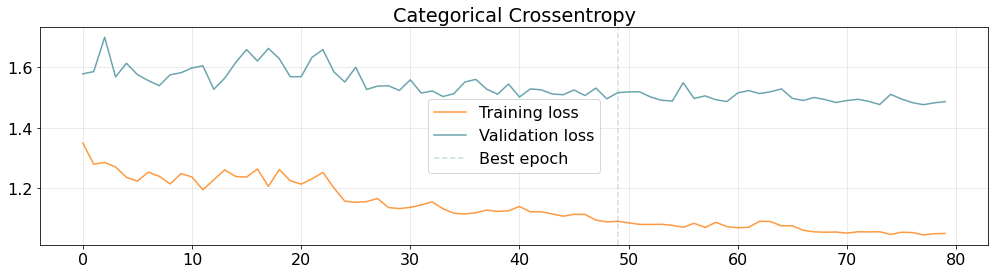

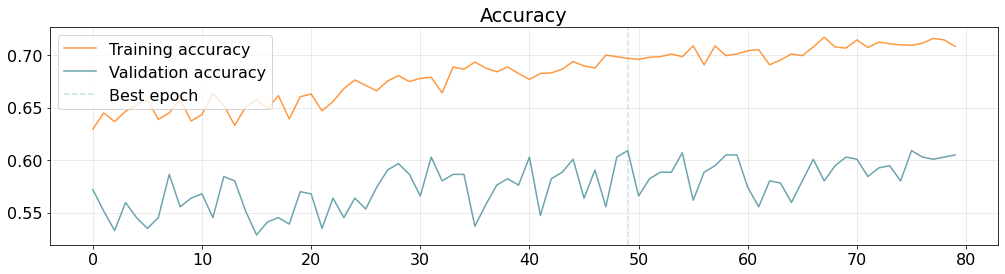

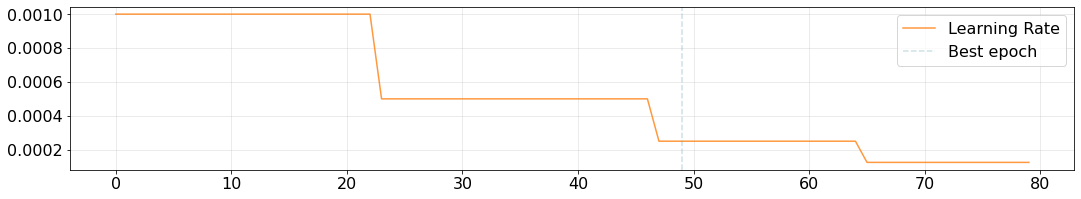

In [17]:
best_epoch = np.argmax(history1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

16/16 [==============================] - 0s 2ms/step - loss: 1.5162 - accuracy: 0.6091
{'loss': 1.5161962509155273, 'accuracy': 0.6090534925460815}
Accuracy: 0.6091
Precision: 0.4223
Recall: 0.399
F1: 0.3886
F1 (per class): [0.         0.55813953 0.73913043 0.42028986 0.         0.22727273
 0.8028169  0.         0.64864865 0.70157068 0.56521739 0.        ]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


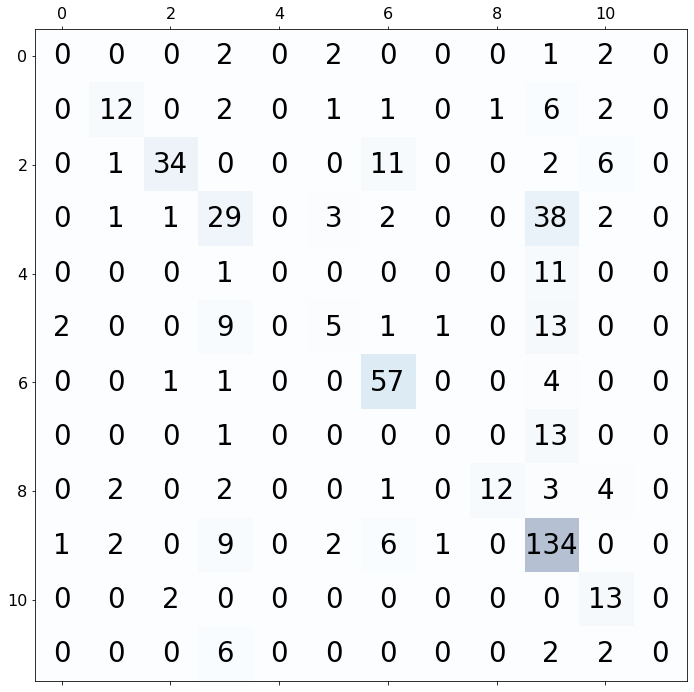

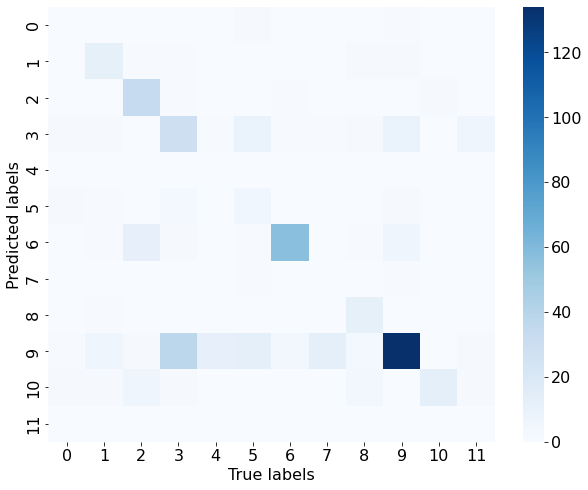

In [18]:
model = best_model 
labels = y_test
metrics = model.evaluate(x=x_test, y=y_test, return_dict=True)
print(metrics)
predictions = model.predict(x_test) 

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [19]:
model.save('BEST')

2022-12-12 00:50:28.728322: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
